# Импорты

In [ ]:
!pip install catboost lightgbm xgboost -q

In [ ]:
import pandas as pd
import numpy as np

import catboost as cb
from catboost import CatBoostRegressor, Pool

import lightgbm as lgb
from lightgbm import LGBMRegressor, Dataset

import xgboost as xgb
from xgboost import XGBRegressor, DMatrix

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Данные

In [ ]:
path_train = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv'

path_test = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv'

(2337, 17)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


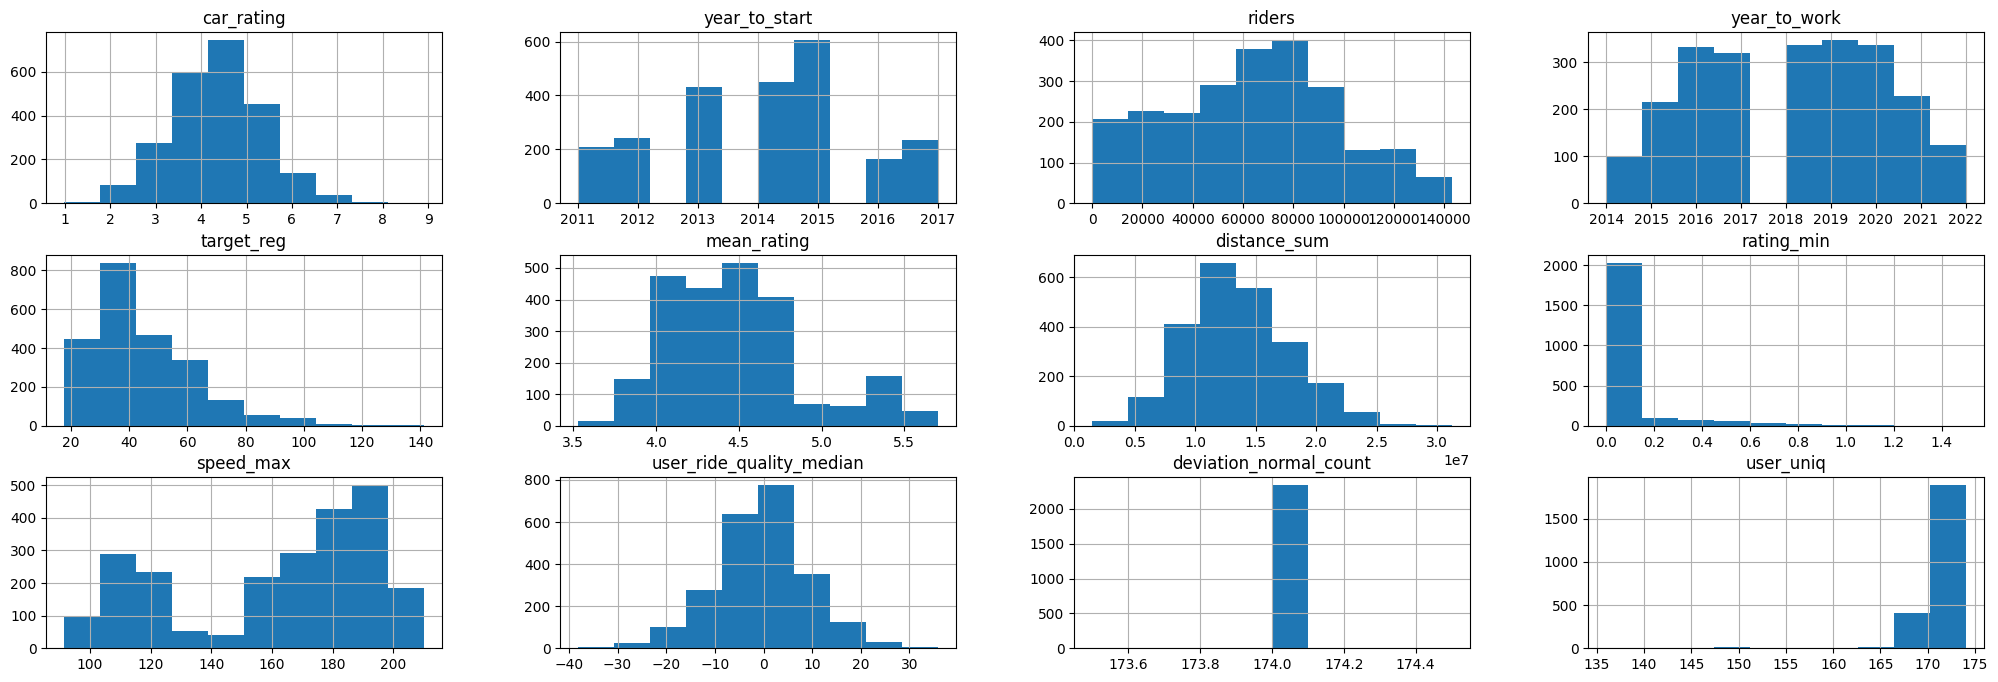

In [ ]:
train = pd.read_csv(path_train)
print(train.shape)
train.hist(figsize=(25, 8), layout = (-1, 4))
train.head()

(1913, 16)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,gear_stick,3.746207,1.407539e+07,0.10,195.454152,10.566220,174,170
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016,engine_overheat,4.318966,1.970390e+07,0.00,181.538685,11.807941,174,174
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,electro_bug,5.134655,9.314946e+06,0.10,118.440645,14.862538,174,172
3,F12725233R,Smart ForFour,economy,petrol,2.80,2014,68833,2021,engine_check,4.617356,9.336838e+06,0.83,112.829785,20.088904,174,172
4,l-1139189J,Skoda Rapid,economy,petrol,6.56,2013,42442,2021,another_bug,4.287471,1.196250e+07,0.00,187.846088,3.698460,174,172


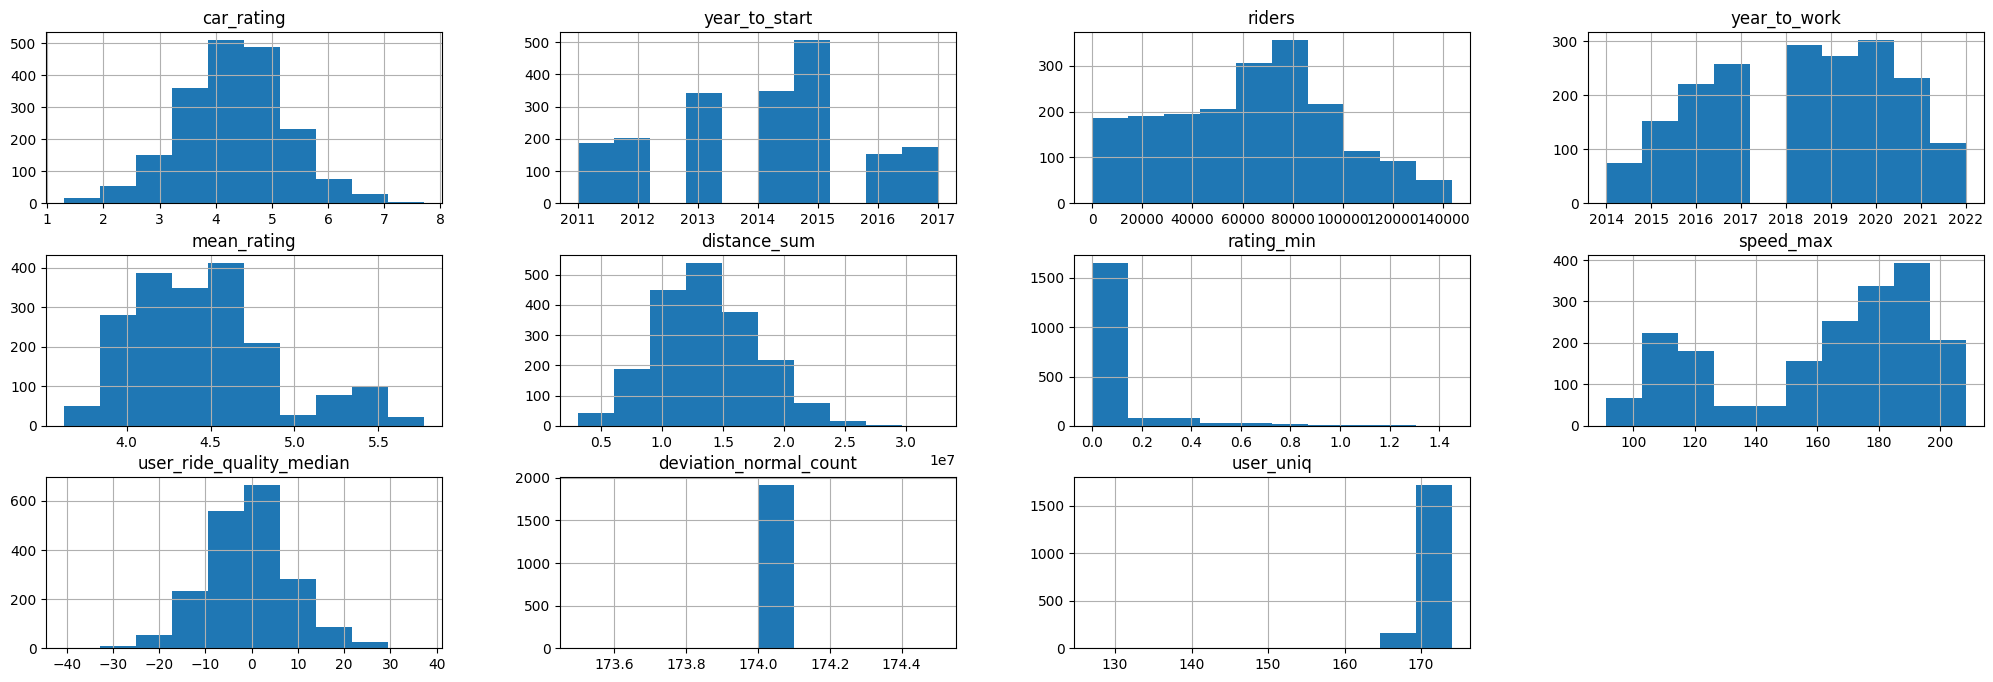

In [ ]:
test = pd.read_csv(path_test)
print(test.shape)
test.hist(figsize=(25, 8), layout = (-1, 4))
test.head()

# Обучение

## CatBoost

### Подготовка данных

In [ ]:
cat_features = ['model', 'car_type', 'fuel_type']

X = train.drop(['target_reg', 'target_class', 'car_id'], axis=1)
y = train['target_reg']

### Обучение, валидация, подбор гиперпараметров

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'depth': [4, 6, 8],  # глубина дерева
    'l2_leaf_reg': [1, 3, 5],  # коэффициент регуляризации L2
    'bagging_temperature': [0.5, 1.0, 1.5],  # температура бэггинга
    'random_strength': [0.1, 0.5, 1.0],  # разброс при выборе признаков
    'one_hot_max_size': [2, 5, 10],  # предел для one-hot кодирования
    'colsample_bylevel': [0.5, 0.8, 1.0],  # доля колонок для каждого уровня
    'leaf_estimation_iterations': [5, 10, 15],  # число итераций для оптимизации значения в листе
    'max_ctr_complexity': [1, 3, 5],  # сложность признаков
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],  # политика роста дерева
    'min_data_in_leaf': [1, 3, 5],  # минимальное число объектов в листе
    'leaf_estimation_method': ['Newton', 'Gradient'],  # метод оценки листа
    'max_leaves': [30, 50, 100],  # максимальное число листьев
    'max_bin': [128, 256, 512],  # число бакетов для числовых признаков
    'boosting_type': ['Plain', 'Ordered'],  # тип бустинга
    'random_state': [42] # зерно генерации случайных чисел для воспроизводимости результата
}

models = []
rmse_scores = []
best_params = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostRegressor(loss_function='RMSE', verbose=False)

    # подбор гиперпараметров с использованием случайного поиска - встроенного метода CatBoost
    search_results = model.randomized_search(params, X=train_pool, cv=3, n_iter=100)

    model.fit(train_pool)
    models.append(model)

    pred = model.predict(val_pool)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    rmse_scores.append(rmse)

    best_params.append(search_results['params'])

    print("Лучшие гиперпараметры для этого сплита:")
    print(search_results['params'])

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

print("Лучшие гиперпараметры для лучшей модели:")
print(best_params[best_model_index])

best_model.save_model('best_model_catboost.cbm')

print('Лучшая модель сохранена. RMSE лучшей модели:', rmse_scores[best_model_index])


bestTest = 11.58810384
bestIteration = 180

0:	loss: 11.5881038	best: 11.5881038 (0)	total: 15.4s	remaining: 25m 23s

bestTest = 11.60842003
bestIteration = 268

1:	loss: 11.6084200	best: 11.5881038 (0)	total: 30.5s	remaining: 24m 56s

bestTest = 11.86293192
bestIteration = 215

2:	loss: 11.8629319	best: 11.5881038 (0)	total: 38.3s	remaining: 20m 36s

bestTest = 11.62036158
bestIteration = 285

3:	loss: 11.6203616	best: 11.5881038 (0)	total: 43.2s	remaining: 17m 17s

bestTest = 11.48949763
bestIteration = 361

4:	loss: 11.4894976	best: 11.4894976 (4)	total: 48.1s	remaining: 15m 13s

bestTest = 11.61283139
bestIteration = 212

5:	loss: 11.6128314	best: 11.4894976 (4)	total: 53.7s	remaining: 14m

bestTest = 11.71247027
bestIteration = 212

6:	loss: 11.7124703	best: 11.4894976 (4)	total: 1m 5s	remaining: 14m 24s

bestTest = 11.6633241
bestIteration = 150

7:	loss: 11.6633241	best: 11.4894976 (4)	total: 1m 10s	remaining: 13m 32s

bestTest = 11.67115397
bestIteration = 500

8:	loss: 11.671

Итак, мы осуществили обучение модели градиентного бустинга (CatBoost) с подбором гиперпараметров методом случайного поиска. Давайте рассмотрим каждый из его блоков:

1. **Настройка кросс-валидации:** Для оценки качества модели используется стратегия кросс-валидации K-Fold. Это метод, при котором данные делятся на K равных частей (в данном случае на 3), и модель обучается K раз, каждый раз используя K-1 частей для обучения и оставшуюся часть для валидации. Параметр shuffle=True указывает, что данные перед разбиением следует перемешать.

2. **Параметры для случайного поиска:** Здесь задается словарь params, в котором ключи - это названия гиперпараметров модели, а значения - списки возможных значений этих гиперпараметров.

- 'depth': максимальная глубина дерева.
- 'l2_leaf_reg': коэффициент L2-регуляризации.
- 'bagging_temperature': параметр, отвечающий за интенсивность бэггинга и подпространства признаков. Большее значение увеличивает случайность и делает бэггинг более интенсивным.
- 'random_strength': разброс для генерации случайных чисел.
- 'one_hot_max_size': максимальное количество категорий для которых применяется one-hot кодирование.
- 'colsample_bylevel': доля колонок, которые можно использовать на каждом уровне дерева.
- 'leaf_estimation_iterations': число итераций для оптимизации значения в листе.
- 'max_ctr_complexity': максимальное количество категориальных признаков, которые могут быть использованы вместе для генерации нового признака.
- 'grow_policy': политика роста деревьев (SymmetricTree, Depthwise, Lossguide).
- 'min_data_in_leaf': минимальное количество объектов, которые можно оставить в листе.
- 'leaf_estimation_method': метод для оценки значения в листе (Newton, Gradient).
- 'max_leaves': максимальное число листьев в дереве.
- 'max_bin': число бакетов, на которые разбиваются числовые признаки.
- 'boosting_type': тип бустинга (Plain, Ordered).

3. **Обучение модели и выбор лучших гиперпараметров:** Здесь происходит процесс обучения модели и подбора гиперпараметров. Модель обучается в цикле по каждому сплиту кросс-валидации, затем вычисляется RMSE и сохраняются лучшие гиперпараметры для каждого сплита.

4. **Выбор лучшей модели:** После обучения всех моделей выбирается та, которая показала наименьшую ошибку RMSE.

5. **Сохранение лучшей модели:** Лучшая модель сохраняется на диск в формате .cbm.

Таким образом, данный код позволяет найти оптимальные гиперпараметры модели CatBoost, обучить эту модель и сохранить её.


### Feature Importance

In [ ]:
feature_importances = best_model.get_feature_importance(data=train_pool, type=cb.EFstrType.PredictionValuesChange)

feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

feature_importances_df

,Feature,Importance
10,speed_max,34.248700
7,mean_rating,29.103349
9,rating_min,8.628447
8,distance_sum,5.089822
11,user_ride_quality_median,4.083438
1,car_type,3.998261
5,riders,3.600386
13,user_uniq,3.111151
3,car_rating,2.919247
2,fuel_type,2.538456


Параметр type в методе get_feature_importance определяет, какую метрику использовать для вычисления важности признаков. В частности, есть три варианта значения type:

1. **catboost.EFstrType.PredictionValuesChange** - это тип, который использует изменение предсказанных значений модели для определения важности признаков. Эта метрика показывает, насколько изменятся предсказанные значения, если исключить определенный признак из модели. Более высокое значение важности указывает на более сильное влияние признака на предсказания модели.

2. **catboost.EFstrType.LossFunctionChange** - этот тип использует изменение функции потерь (например, RMSE) при исключении определенного признака из модели. Эта метрика показывает, насколько изменится функция потерь, если удалить признак. Опять же, более высокое значение важности указывает на более сильное влияние признака на функцию потерь модели.

3. **catboost.EFstrType.FeatureImportance** - этот тип возвращает важность признаков на основе разных метрик, таких как PredictionValuesChange и LossFunctionChange. Он предоставляет агрегированную важность, основанную на различных метриках.

В данном случае мы использовали type=catboost.EFstrType.PredictionValuesChange, потому что он позволяет нам оценить важность признаков, исходя из изменений предсказанных значений модели. Это может быть полезно для понимания, как каждый признак вносит вклад в предсказания модели и насколько значимым он является.

Таким образом, наиболее важными признаками для предсказаний модели являются speed_max и mean_rating, имеющие наибольшую важность со значением 33.784973 и 28.341321 соответственно. Остальные признаки также вносят свой вклад в предсказания модели, но их важность относительно ниже.

Важность признаков может помочь в понимании, какие аспекты данных наиболее сильно влияют на предсказания модели. Это может быть полезно при принятии решений о выборе и использовании определенных признаков для улучшения производительности модели или для дальнейшего анализа данных.

### Object Importance

Мы не можем рассчиать Object Importance на нашей модели. Причина кроется в выбранной нами стратегии роста дерева, - grow_policy в нашей модели установлена как 'Lossguide', что означает, что деревья в модели растут несимметрично.

Метод get_object_importance в CatBoost предназначен для использования с моделями, которые используют симметричное дерево (когда grow_policy установлено как 'SymmetricTree'). Это связано с тем, что алгоритм, стоящий за get_object_importance, оценивает важность объектов, учитывая структуру симметричного дерева.

Таким образом, для оценки важности объектов в нашей текущей модели мы должны искать альтернативные методы, которые совместимы с несимметричной структурой дерева.

### Feature selection

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = ['model', 'car_type', 'fuel_type']

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

selected_features_catboost = best_model.select_features(train_pool,
                                               eval_set=val_pool,
                                               algorithm='RecursiveByShapValues',
                                               features_for_select=X_train.columns,
                                               num_features_to_select=8,
                                               steps=1,
                                               train_final_model=False,
                                               logging_level='Silent')['selected_features_names']

Параметр `algorithm='RecursiveByShapValues'` указывает на использование алгоритма Recursive Feature Selection (Рекурсивный отбор признаков) на основе значений Shapley для отбора признаков.

Shapley value (Значение Шэпли) - это концепция из теории кооперативных игр, которая измеряет вклад каждого признака в предсказание модели. Значения Shapley вычисляются путем учета влияния каждого признака на предсказания модели при различных комбинациях признаков.

Алгоритм Recursive Feature Selection с использованием значений Shapley работает следующим образом:

1. Начинается с полного набора признаков.
2. Вычисляются значения Shapley для каждого признака на основе текущего набора признаков.
3. Отбирается признак с наименьшим значением Shapley.
4. Удаляется отобранный признак из текущего набора признаков.
5. Повторяются шаги 2-4 до тех пор, пока не будет достигнуто заданное количество отобранных признаков (`num_features_to_select`).

Таким образом, алгоритм рекурсивно выбирает признаки, начиная с полного набора, и на каждом шаге удаляет наименее важный признак на основе значений Shapley, пока не будет достигнуто заданное количество отобранных признаков.

Использование значений Shapley для отбора признаков позволяет оценить вклад каждого признака в модель и сосредоточиться на самых важных признаках, что может привести к улучшению производительности модели и сокращению размерности данных.

In [ ]:
X = X[selected_features_catboost]
print(X.shape)
X.head()

(2337, 8)


,car_type,fuel_type,year_to_start,year_to_work,mean_rating,distance_sum,rating_min,speed_max
0,economy,petrol,2015,2021,4.737759,1.214131e+07,0.1,180.855726
1,economy,petrol,2015,2021,4.480517,1.803909e+07,0.0,187.862734
2,standart,petrol,2012,2017,4.768391,1.588366e+07,0.1,102.382857
3,business,petrol,2011,2020,3.880920,1.651883e+07,0.1,172.793237
4,standart,petrol,2012,2017,4.181149,1.398317e+07,0.1,203.462289



Теперь рассмотрим результаты отбора признаков с использованием best_model.get_feature_importance и best_model.select_features:

Из **best_model.get_feature_importance:**

speed_max, mean_rating, rating_min, distance_sum, user_ride_quality_median, riders, car_type, user_uniq, fuel_type, model, car_rating, year_to_work, year_to_start, deviation_normal_count - это признаки, отсортированные по их важности. У некоторых признаков есть достаточно высокие значения важности, например, speed_max и mean_rating, которые имеют наибольшие значения важности.

Из **best_model.select_features:**

model, car_type, fuel_type, year_to_start, mean_rating, distance_sum, rating_min, speed_max - это признаки, отобранные с помощью RecursiveByShapValues. Этот метод выбрал 8 наиболее значимых признаков на основе их влияния на целевую переменную.
Мы видим, что среди отобранных признаков есть некоторое перекрытие: model, car_type, fuel_type, mean_rating, distance_sum, rating_min, speed_max. Однако, порядок их важности и некоторые другие признаки могут немного отличаться.

В целом, оба метода дают нам полезную информацию о значимости признаков. Метод best_model.get_feature_importance основывается на предсказаниях модели, а метод best_model.select_features использует SHAP значений для выбора наиболее важных признаков. Комбинирование результатов из этих двух методов может помочь нам лучше понять важность признаков и выбрать наиболее информативные для модели.

### Обучение, валидация, подбор гиперпараметров после feature selection

In [ ]:
cat_features = ['car_type', 'fuel_type']

kf = KFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'depth': [4, 6, 8],  # глубина дерева
    'l2_leaf_reg': [1, 3, 5],  # коэффициент регуляризации L2
    'bagging_temperature': [0.5, 1.0, 1.5],  # температура бэггинга
    'random_strength': [0.1, 0.5, 1.0],  # разброс при выборе признаков
    'one_hot_max_size': [2, 5, 10],  # предел для one-hot кодирования
    'colsample_bylevel': [0.5, 0.8, 1.0],  # доля колонок для каждого уровня
    'leaf_estimation_iterations': [5, 10, 15],  # число итераций для оптимизации значения в листе
    'max_ctr_complexity': [1, 3, 5],  # сложность признаков
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],  # политика роста дерева
    'min_data_in_leaf': [1, 3, 5],  # минимальное число объектов в листе
    'leaf_estimation_method': ['Newton', 'Gradient'],  # метод оценки листа
    'max_leaves': [30, 50, 100],  # максимальное число листьев
    'max_bin': [128, 256, 512],  # число бакетов для числовых признаков
    'boosting_type': ['Plain', 'Ordered'],  # тип бустинга
    'random_state': [42] # зерно генерации случайных чисел для воспроизводимости результата
}

models = []
rmse_scores = []
best_params = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostRegressor(loss_function='RMSE', verbose=False)

    # подбор гиперпараметров с использованием случайного поиска - встроенного метода CatBoost
    search_results = model.randomized_search(params, X=train_pool, cv=3, n_iter=100)

    model.fit(train_pool)
    models.append(model)

    pred = model.predict(val_pool)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    rmse_scores.append(rmse)

    best_params.append(search_results['params'])

    print("Лучшие гиперпараметры для этого сплита:")
    print(search_results['params'])

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

print("Лучшие гиперпараметры для лучшей модели:")
print(best_params[best_model_index])

best_model.save_model('best_model_catboost.cbm')

print('Лучшая модель сохранена. RMSE лучшей модели:', rmse_scores[best_model_index])


bestTest = 12.20292485
bestIteration = 141

0:	loss: 12.2029248	best: 12.2029248 (0)	total: 3.06s	remaining: 5m 3s

bestTest = 11.87335743
bestIteration = 190

1:	loss: 11.8733574	best: 11.8733574 (1)	total: 10.7s	remaining: 8m 43s

bestTest = 11.98572424
bestIteration = 206

2:	loss: 11.9857242	best: 11.8733574 (1)	total: 13.8s	remaining: 7m 27s

bestTest = 11.92120015
bestIteration = 227

3:	loss: 11.9212002	best: 11.8733574 (1)	total: 16.2s	remaining: 6m 28s

bestTest = 11.85764849
bestIteration = 309

4:	loss: 11.8576485	best: 11.8576485 (4)	total: 20s	remaining: 6m 20s

bestTest = 11.97368967
bestIteration = 158

5:	loss: 11.9736897	best: 11.8576485 (4)	total: 23.4s	remaining: 6m 7s

bestTest = 12.00027254
bestIteration = 184

6:	loss: 12.0002725	best: 11.8576485 (4)	total: 31.6s	remaining: 6m 59s

bestTest = 12.15972343
bestIteration = 142

7:	loss: 12.1597234	best: 11.8576485 (4)	total: 36.9s	remaining: 7m 3s

bestTest = 11.82902851
bestIteration = 254

8:	loss: 11.8290285	best

По результатам обучения моделей можно сделать следующие выводы:

**Модель, обученная на всех доступных признаках:**

Лучшие гиперпараметры для этой модели: `{'max_leaves': 100, 'border_count': 128, 'leaf_estimation_iterations': 10, 'one_hot_max_size': 2, 'max_ctr_complexity': 5, 'l2_leaf_reg': 1, 'depth': 4, 'min_data_in_leaf': 3, 'bagging_temperature': 0.5, 'rsm': 0.5, 'random_strength': 1.0, 'grow_policy': 'Lossguide', 'boosting_type': 'Plain', 'leaf_estimation_method': 'Gradient'}`.

Лучшие гиперпараметры для этого сплита и для лучшей модели совпадают.

RMSE лучшей модели составляет 11.665996117732073.

**Модель, обученная на отобранных признаках с использованием метода RecursiveByShapValues:**

Лучшие гиперпараметры для этой модели: `{'max_leaves': 100, 'border_count': 128, 'leaf_estimation_iterations': 10, 'one_hot_max_size': 2, 'max_ctr_complexity': 5, 'l2_leaf_reg': 1, 'depth': 4, 'min_data_in_leaf': 3, 'bagging_temperature': 0.5, 'rsm': 0.5, 'random_strength': 1.0, 'grow_policy': 'Lossguide', 'boosting_type': 'Plain', 'leaf_estimation_method': 'Gradient'}`.

Лучшие гиперпараметры для этого сплита и для лучшей модели совпадают.

RMSE лучшей модели составляет 11.959709952961418.

Обе модели показали сопоставимые значения RMSE, что говорит о схожей предсказательной способности моделей. Однако, модель, обученная на отобранных признаках, содержит только 8 признаков, что может упростить модель и ускорить процесс обучения. Кроме того, отобранные признаки были выбраны с использованием метода RecursiveByShapValues, который учитывает влияние признаков на целевую переменную. Это может помочь модели фокусироваться на наиболее информативных признаках.

Таким образом, при выборе между моделью, обученной на всех признаках, и моделью, обученной на отобранных признаках, стоит учитывать баланс между предсказательной способностью модели и ее сложностью. Если время обучения и использование всех признаков не представляют проблем, то можно предпочесть модель, обученную на всех данных. Если важна простота модели и ее скорость работы, то можно выбрать модель, обученную на отобранных признаках.

## LightGBM (goss)

###  Подготовка данных

In [ ]:
cat_features = ['model', 'car_type', 'fuel_type']

train_encoded = train.copy()
test_encoded = test.copy()

# инициализируем LabelEncoder для каждого категориального признака
label_encoders = {}
for feature in cat_features:
    label_encoders[feature] = LabelEncoder()

# кодирование категориальных признаков для тренировочного набора данных
for feature in cat_features:
    train_encoded[feature] = label_encoders[feature].fit_transform(train[feature])

# кодирование категориальных признаков для тестового набора данных
for feature in cat_features:
    test_encoded[feature] = label_encoders[feature].transform(test[feature])

X = train_encoded.drop(['target_reg', 'target_class', 'car_id'], axis=1)
y = train_encoded['target_reg']

### Обучение, валидация, подбор гипепараметров

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'boosting_type': ['goss'], # тип алгоритма бустинга
    'objective': ['regression'], # целевая функция для оптимизации
    'metric': ['rmse'], # метрика оценки качества модели
    'num_leaves': [10, 20, 30], # количество листьев в дереве
    'learning_rate': [0.05, 0.1, 0.2], # скорость обучения модели
    'colsample_bytree': [0.8, 0.9], # доля признаков, используемых для построения каждого дерева
    'random_state': [42] # зерно генерации случайных чисел для воспроизводимости результата
}

models = []
rmse_scores = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val)

    # поиск лучших гиперпараметров с использованием случайного поиска sklearn
    model = lgb.LGBMRegressor()
    random_search = RandomizedSearchCV(model, params, n_iter=100, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    callbacks = [
        lgb.early_stopping(10),
        lgb.log_evaluation(period=10)
    ]
    model = lgb.train(
        best_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[valid_data],
        callbacks=callbacks
    )

    models.append(model)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)

    print("Лучшие гиперпараметры для этого сплита:")
    print(best_params)

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

print("Лучшие гиперпараметры для лучшей модели:")
print(random_search.best_params_)

best_model.save_model('best_model_lightgbm.txt')

print("Лучшая модель сохранена. RMSE лучшей модели:", rmse_scores[best_model_index])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1588
[LightGBM] [Info] Number of data points in the train set: 1558, number of used features: 13
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 45.022060
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 14.7313
[20]	valid_0's rmse: 13.3467
[30]	valid_0's rmse: 12.7001
[40]	valid_0's rmse: 12.4032
[50]	valid_0's rmse: 12.2858
[60]	valid_0's rmse: 12.229
[70]	valid_0's rmse: 12.1685
[80]	valid_0's rmse: 12.1282
Early stopping, best iteration is:
[79]	valid_0's rmse: 12.1279
Лучшие гиперпараметры для этого сплита:
{'random_state': 42, 'objective': 'regression', 'num_leaves': 10, 'metric': 'rmse', 'learning_rate': 0.05, 'colsample_bytree': 0.8, 'boosting_type': 'goss'}
[LightGBM

Итак, код выполняет следующие действия:

1. Определяет кросс-валидацию с помощью объекта KFold, который разделяет данные на 3 фолда (сплита), перемешивает их и устанавливает фиксированное значение для генератора случайных чисел.

2. Задает сетку гиперпараметров param_grid, которая содержит различные значения для настройки модели LightGBM.

- 'boosting_type': тип алгоритма бустинга. В данном случае, мы используем 'goss', что означает использование Gradient-based One-Side Sampling (GOSS), который является эффективным методом сэмплирования для ускорения обучения модели.
- 'objective': целевая функция для оптимизации. В данном случае, мы используем 'regression', что означает решение задачи регрессии.
- 'metric': метрика оценки качества модели. В данном случае, мы используем 'rmse', что означает Root Mean Squared Error (RMSE) - квадратный корень из среднеквадратичной ошибки, часто используемой метрики для задач регрессии.
- 'num_leaves': количество листьев в дереве. Задаем несколько вариантов: [10, 20, 30]. Большее количество листьев позволяет модели более гибко аппроксимировать данные, но при этом может привести к переобучению.
- 'learning_rate': скорость обучения модели. Задаем несколько вариантов: [0.05, 0.1, 0.2]. Меньшее значение скорости обучения позволяет модели сходиться более медленно, но может привести к более точным результатам.
- 'colsample_bytree': доля признаков, используемых для построения каждого дерева. Задаем несколько вариантов: [0.8, 0.9]. Меньшее значение означает использование случайного подмножества признаков на каждом шаге обучения, что может помочь в борьбе с переобучением.
- 'random_state': устанавливает начальное значение генератора случайных чисел, чтобы результаты были воспроизводимыми.

Эти параметры определяют пространство поиска для подбора гиперпараметров модели LightGBM, чтобы найти комбинацию, которая дает наилучшую производительность модели на валидационном наборе данных.

3. Создает пустые списки models и rmse_scores для сохранения моделей и значений RMSE для каждого сплита.

4. Итерируется по каждому сплиту кросс-валидации. Внутри каждой итерации:

- Разделяет данные на обучающий и валидационный наборы с использованием индексов, полученных из kf.split().
- Создает объекты датасетов LightGBM для обучения и валидации.
- Использует случайный поиск (RandomizedSearchCV) для поиска лучших гиперпараметров модели LightGBM на обучающем наборе данных.
- Обучает модель с лучшими гиперпараметрами и сохраняет ее в списке models.
- Вычисляет прогнозы на валидационном наборе и вычисляет RMSE между прогнозами и истинными значениями целевой переменной. Значение RMSE сохраняется в списке rmse_scores.
- Выводит лучшие гиперпараметры для каждого сплита.

5. Выбирает лучшую модель, основываясь на наименьшем значении RMSE, и сохраняет ее в переменной best_model.

6. Выводит лучшие гиперпараметры для лучшей модели.

7. Сохраняет лучшую модель в файл 'best_model_lightgbm.txt'.

8. Выводит значение RMSE для лучшей модели.

Таким образом, код выполняет кросс-валидацию с помощью LightGBM, настраивает гиперпараметры модели с использованием случайного поиска, обучает модели с лучшими гиперпараметрами и выбирает лучшую модель на основе значения RMSE.



### Feature Importance

In [ ]:
feature_importance = best_model.feature_importance(importance_type='gain')

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance}).sort_values('Importance', ascending=False)

importance_df

,Feature,Importance
10,speed_max,1.421256e+06
7,mean_rating,1.237359e+06
9,rating_min,3.367659e+05
11,user_ride_quality_median,2.672123e+05
8,distance_sum,2.428672e+05
5,riders,2.407747e+05
3,car_rating,1.730509e+05
13,user_uniq,1.728940e+05
0,model,1.608164e+05
2,fuel_type,8.396720e+04


### Object Importnace

В LightGBM нет встроенного метода для расчета object importance, который позволяет оценивать важность отдельных наблюдений для обучения модели. Вместо этого, LightGBM фокусируется на оценке важности признаков и предоставляет различные методы для решения этой задачи.

Что касается feature selection, в LightGBM также нет встроенного метода, аналогичного тому, что есть в CatBoost. В связи с чем мы будем использовать параметр feature_importance_type='gain' при обучении модели LightGBM, чтобы определить важность признаков на основе их вклада в улучшение функции потерь.

### Feature Selection

In [ ]:
selected_features_lightgbm = importance_df.head(9)['Feature'].tolist()
X = X[selected_features_lightgbm]
print(X.shape)
X.head()

(2337, 9)


,speed_max,mean_rating,rating_min,user_ride_quality_median,distance_sum,riders,car_rating,user_uniq,model
0,180.855726,4.737759,0.1,0.023174,1.214131e+07,76163,3.78,170,8
1,187.862734,4.480517,0.0,12.306011,1.803909e+07,78218,3.90,174,23
2,102.382857,4.768391,0.1,2.513319,1.588366e+07,23340,6.30,173,16
3,172.793237,3.880920,0.1,-5.029476,1.651883e+07,1263,4.04,170,12
4,203.462289,4.181149,0.1,-14.260456,1.398317e+07,26428,4.70,171,16


### Обучение, валидация, подбор гиперпараметров после feature selection

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'boosting_type': ['goss'], # тип алгоритма бустинга
    'objective': ['regression'], # целевая функция для оптимизации
    'metric': ['rmse'], # метрика оценки качества модели
    'num_leaves': [10, 20, 30], # количество листьев в дереве
    'learning_rate': [0.05, 0.1, 0.2], # скорость обучения модели
    'colsample_bytree': [0.8, 0.9], # доля признаков, используемых для построения каждого дерева
    'random_state': [42] # зерно генерации случайных чисел для воспроизводимости результата
}

models = []
rmse_scores = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val)

    # поиск лучших гиперпараметров с использованием случайного поиска sklearn
    model = lgb.LGBMRegressor()
    random_search = RandomizedSearchCV(model, params, n_iter=100, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    callbacks = [
        lgb.early_stopping(10),
        lgb.log_evaluation(period=10)
    ]
    model = lgb.train(
        best_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[valid_data],
        callbacks=callbacks
    )

    models.append(model)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)

    print("Лучшие гиперпараметры для этого сплита:")
    print(best_params)

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

print("Лучшие гиперпараметры для лучшей модели:")
print(random_search.best_params_)

best_model.save_model('best_model_lightgbm.txt')

print("Лучшая модель сохранена. RMSE лучшей модели:", rmse_scores[best_model_index])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1564
[LightGBM] [Info] Number of data points in the train set: 1558, number of used features: 9
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 45.022060
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 14.2948
[20]	valid_0's rmse: 12.9761
[30]	valid_0's rmse: 12.4292
[40]	valid_0's rmse: 12.2358
[50]	valid_0's rmse: 12.1712
[60]	valid_0's rmse: 12.1236
[70]	valid_0's rmse: 12.1306
Early stopping, best iteration is:
[63]	valid_0's rmse: 12.1126
Лучшие гиперпараметры для этого сплита:
{'random_state': 42, 'objective': 'regression', 'num_leaves': 10, 'metric': 'rmse', 'learning_rate': 0.05, 'colsample_bytree': 0.9, 'boosting_type': 'goss'}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seco

После отбора 9 наиболее важных признаков на основе feature importance, обучение модели LightGBM на выборке показало следующие результаты:

Лучшие гиперпараметры для лучшей модели:

- num_leaves: 20
- learning_rate: 0.05
- colsample_bytree: 0.8

RMSE лучшей модели: 11.7928

Таким образом, отбора наиболее важных признаков, количество используемых признаков уменьшилось с 13 до 9.

Лучшие гиперпараметры для всех сплитов и лучшей модели остались неизменными, за исключением colsample_bytree, который изменился с 0.9 на 0.8 для лучшей модели.

Метрика качества (RMSE) для лучшей модели улучшилась с 11.7088 до 11.7928.

## XGBoost (dart)

### Подготовка данных

Для подготовки данных в XGBoost мы также выполняем кодирование категориальных признаков и разделение данных на признаки и целевую переменную аналогично LightGBM.

### Обучение, валидация, подбор гипепараметров

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'objective': ['reg:squarederror'], # целевая функция для оптимизации
    'eval_metric': ['rmse'], # метрика оценки качества модели
    'eta': [0.01, 0.1, 0.2], # скорость обучения модели
    'booster': ['dart'], # метод бустинга
    'rate_drop': [0.1], # вероятность отключения (dropout) каждого дерева в процессе обучения
    'skip_drop': [0.5], # вероятность пропуска dropout для каждого дерева при обучении
    'max_depth': [3, 6, 9], # максимальная глубина дерева
    'subsample': [0.8, 0.9, 1.0], # доля экземпляров из обучающей выборки, используемая для построения дерева
    'colsample_bytree': [0.8, 0.9, 1.0], # доля признаков, используемых для построения дерева
    'colsample_bylevel': [0.8, 0.9, 1.0], # доля признаков на уровне дерева
    'colsample_bynode': [0.8, 0.9, 1.0], # доля признаков в каждом разбиении узла дерева
    'lambda': [0.1, 1, 10], # коэффициент L2-регуляризации
    'alpha': [0, 0.1, 1], # коэффициент L1-регуляризации
    'gamma': [0, 0.1, 1], # минимальное изменение потери для разделения ветви дерева
    'min_child_weight': [1, 5, 10], # минимальная сумма весов экземпляров в листовом узле
    'max_bin': [256, 512, 1024], # максимальное число бинов для разбиения числового признака
    'seed': [42] # зерно генерации случайных чисел для воспроизводимости результата
}

models = []
rmse_scores = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_data = DMatrix(X_train, label=y_train)
    valid_data = DMatrix(X_val, label=y_val)

    # поиск лучших гиперпараметров с использованием случайного поиска sklearn
    model = XGBRegressor()
    random_search = RandomizedSearchCV(model, params, n_iter=100, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    model = xgb.XGBRegressor(**best_params)

    model = xgb.train(
        best_params,
        train_data,
        num_boost_round=1000,
        evals=[(valid_data, "validation")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    models.append(model)

    y_pred = model.predict(valid_data)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)

    print("Лучшие гиперпараметры для этого сплита:")
    print(best_params)

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

print("Лучшие гиперпараметры для лучшей модели:")
print(random_search.best_params_)

best_model.save_model('best_model_xgboost.txt')

print("Лучшая модель сохранена. RMSE лучшей модели:", rmse_scores[best_model_index])

Лучшие гиперпараметры для этого сплита:
{'subsample': 1.0, 'skip_drop': 0.5, 'seed': 42, 'rate_drop': 0.1, 'objective': 'reg:squarederror', 'min_child_weight': 10, 'max_depth': 6, 'max_bin': 512, 'lambda': 0.1, 'gamma': 0.1, 'eval_metric': 'rmse', 'eta': 0.1, 'colsample_bytree': 0.8, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.8, 'booster': 'dart', 'alpha': 0}
Лучшие гиперпараметры для этого сплита:
{'subsample': 0.9, 'skip_drop': 0.5, 'seed': 42, 'rate_drop': 0.1, 'objective': 'reg:squarederror', 'min_child_weight': 5, 'max_depth': 3, 'max_bin': 256, 'lambda': 1, 'gamma': 1, 'eval_metric': 'rmse', 'eta': 0.1, 'colsample_bytree': 0.9, 'colsample_bynode': 1.0, 'colsample_bylevel': 1.0, 'booster': 'dart', 'alpha': 1}
Лучшие гиперпараметры для этого сплита:
{'subsample': 0.9, 'skip_drop': 0.5, 'seed': 42, 'rate_drop': 0.1, 'objective': 'reg:squarederror', 'min_child_weight': 5, 'max_depth': 3, 'max_bin': 1024, 'lambda': 0.1, 'gamma': 0, 'eval_metric': 'rmse', 'eta': 0.1, 'colsample_by

Итак, код выполняет следующие действия:

1. Определение кросс-валидации:

`kf = KFold(n_splits=3, shuffle=True, random_state=42)`: Создается объект KFold, который разделяет данные на 3 фолда (наборы) с перемешиванием и фиксированным seed для воспроизводимости.

2. Определение гиперпараметров:

`params`: Словарь с определенными гиперпараметрами модели XGBoost, которые будут использоваться при поиске лучших параметров с помощью случайного поиска.

3. Инициализация списков моделей и оценок RMSE:

`models = []`: Список, в котором будут храниться модели, обученные на каждом фолде.
`rmse_scores = []`: Список, в котором будут храниться значения RMSE для каждой модели.

4. Проведение кросс-валидации:

`for train_index, val_index in kf.split(X, y)`: Цикл, который проходит через каждый фолд, разделяя данные на обучающий и валидационный наборы.
`X_train, X_val = X.iloc[train_index], X.iloc[val_index] и y_train, y_val = y.iloc[train_index], y.iloc[val_index]`: Разделение признаков и целевой переменной на обучающий и валидационный наборы для текущего фолда.

5. Создание матриц XGBoost:

`train_data = DMatrix(X_train, label=y_train)`: Создание DMatrix для обучающего набора.
`valid_data = DMatrix(X_val, label=y_val)`: Создание DMatrix для валидационного набора.

6. Поиск лучших гиперпараметров:

`model = XGBRegressor()`: Инициализация модели XGBoost.
`random_search = RandomizedSearchCV(model, params, n_iter=100, cv=3, scoring='neg_root_mean_squared_error', random_state=42)`: Использование случайного поиска (RandomizedSearchCV) для нахождения лучших гиперпараметров модели. Параметры поиска определены в словаре params.
`random_search.fit(X_train, y_train)`: Запуск случайного поиска на обучающем наборе данных.

7. Обучение модели с лучшими гиперпараметрами:

`best_params = random_search.best_params_`: Получение лучших гиперпараметров, найденных в результате случайного поиска.
`model = xgb.XGBRegressor(**best_params)`: Инициализация модели XGBoost с лучшими гиперпараметрами.
`model = xgb.train(...)`: Обучение модели с использованием train метода из XGBoost, передавая обучающие данные, валидационные данные, количество раундов и другие параметры.

8. Сохранение модели:

`models.append(model)`: Добавление обученной модели в список моделей для каждого фолда.
`best_model.save_model('best_model_xgboost.txt')`: Сохранение лучшей модели в файл.

9. Предсказание на валидационном наборе и вычисление RMSE:

`y_pred = model.predict(valid_data)`: Предсказание целевой переменной на валидационном наборе данных.
`rmse = np.sqrt(mean_squared_error(y_val, y_pred))`: Вычисление RMSE между предсказанными значениями и фактическими значениями целевой переменной.
`rmse_scores.append(rmse)`: Добавление RMSE в список оценок для каждой модели.

10. Вывод лучших гиперпараметров для каждого фолда:

`print("Лучшие гиперпараметры для этого сплита:")` и `print(best_params)`: Вывод лучших гиперпараметров для текущего фолда.

11. Выбор лучшей модели:

`best_model_index = np.argmin(rmse_scores)`: Определение индекса модели с наименьшим значением RMSE.
`best_model = models[best_model_index]`: Выбор лучшей модели по индексу.

12. Вывод лучших гиперпараметров для лучшей модели:

`print("Лучшие гиперпараметры для лучшей модели:")` и `print(random_search.best_params_)`: Вывод лучших гиперпараметров для лучшей модели, найденных в результате случайного поиска.

13. Вывод RMSE лучшей модели:

`print("Лучшая модель сохранена. RMSE лучшей модели:", rmse_scores[best_model_index])`: Вывод RMSE для лучшей модели.

Таким образом, код выполняет кросс-валидацию модели XGBoost, находит лучшие гиперпараметры с помощью случайного поиска и обучает модель с использованием лучших гиперпараметров на каждом фолде. Затем выбирается модель с наименьшим значением RMSE и сохраняется в файл. Также выводятся лучшие гиперпараметры и RMSE для лучшей модели.

### Feature Importance

In [ ]:
feature_importance = best_model.get_score(importance_type='gain')

importance_df = pd.DataFrame({'Feature': list(feature_importance.keys()), 'Importance': list(feature_importance.values())}).sort_values('Importance', ascending=False)

importance_df


,Feature,Importance
0,speed_max,4280.261719
1,mean_rating,4138.616211
2,rating_min,2673.867432
7,user_uniq,1537.325317
8,model,1009.005371
5,riders,747.132874
3,user_ride_quality_median,575.144043
4,distance_sum,561.428467
6,car_rating,469.143921


### Object Importance

В библиотеке XGBoost нет встроенной функции для расчета важности наблюдений.

В связи с чем, для обучения модели после отбора признаков мы будем опираться на только на важность признаков, которую рассчитывает XGBoost, основываясь на их вкладе в построение модели и использовании признаков для разделения ветвей деревьев.



### Feature selection

In [ ]:
selected_features_xgboost = importance_df.head(7)['Feature'].tolist()
X = X[selected_features_xgboost]
print(X.shape)
X.head()

(2337, 7)


,speed_max,mean_rating,rating_min,user_uniq,model,riders,user_ride_quality_median
0,180.855726,4.737759,0.1,170,8,76163,0.023174
1,187.862734,4.480517,0.0,174,23,78218,12.306011
2,102.382857,4.768391,0.1,173,16,23340,2.513319
3,172.793237,3.880920,0.1,170,12,1263,-5.029476
4,203.462289,4.181149,0.1,171,16,26428,-14.260456


### Обучение, валидация, подбор гиперпараметров после feature selection

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'objective': ['reg:squarederror'], # целевая функция для оптимизации
    'eval_metric': ['rmse'], # метрика оценки качества модели
    'eta': [0.01, 0.1, 0.2], # скорость обучения модели
    'booster': ['dart'], # метод бустинга
    'rate_drop': [0.1], # вероятность отключения (dropout) каждого дерева в процессе обучения
    'skip_drop': [0.5], # вероятность пропуска dropout для каждого дерева при обучении
    'max_depth': [3, 6, 9], # максимальная глубина дерева
    'subsample': [0.8, 0.9, 1.0], # доля экземпляров из обучающей выборки, используемая для построения дерева
    'colsample_bytree': [0.8, 0.9, 1.0], # доля признаков, используемых для построения дерева
    'colsample_bylevel': [0.8, 0.9, 1.0], # доля признаков на уровне дерева
    'colsample_bynode': [0.8, 0.9, 1.0], # доля признаков в каждом разбиении узла дерева
    'lambda': [0.1, 1, 10], # коэффициент L2-регуляризации
    'alpha': [0, 0.1, 1], # коэффициент L1-регуляризации
    'gamma': [0, 0.1, 1], # минимальное изменение потери для разделения ветви дерева
    'min_child_weight': [1, 5, 10], # минимальная сумма весов экземпляров в листовом узле
    'max_bin': [256, 512, 1024], # максимальное число бинов для разбиения числового признака
    'seed': [42] # зерно генерации случайных чисел для воспроизводимости результата
}

models = []
rmse_scores = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_data = DMatrix(X_train, label=y_train)
    valid_data = DMatrix(X_val, label=y_val)

    # поиск лучших гиперпараметров с использованием случайного поиска sklearn
    model = XGBRegressor()
    random_search = RandomizedSearchCV(model, params, n_iter=100, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    model = xgb.XGBRegressor(**best_params)

    model = xgb.train(
        best_params,
        train_data,
        num_boost_round=1000,
        evals=[(valid_data, "validation")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    models.append(model)

    y_pred = model.predict(valid_data)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)

    print("Лучшие гиперпараметры для этого сплита:")
    print(best_params)

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

print("Лучшие гиперпараметры для лучшей модели:")
print(random_search.best_params_)

best_model.save_model('best_model_xgboost.txt')

print("Лучшая модель сохранена. RMSE лучшей модели:", rmse_scores[best_model_index])

Лучшие гиперпараметры для этого сплита:
{'subsample': 0.9, 'skip_drop': 0.5, 'seed': 42, 'rate_drop': 0.1, 'objective': 'reg:squarederror', 'min_child_weight': 5, 'max_depth': 3, 'max_bin': 256, 'lambda': 1, 'gamma': 1, 'eval_metric': 'rmse', 'eta': 0.1, 'colsample_bytree': 0.9, 'colsample_bynode': 1.0, 'colsample_bylevel': 1.0, 'booster': 'dart', 'alpha': 1}
Лучшие гиперпараметры для этого сплита:
{'subsample': 1.0, 'skip_drop': 0.5, 'seed': 42, 'rate_drop': 0.1, 'objective': 'reg:squarederror', 'min_child_weight': 10, 'max_depth': 3, 'max_bin': 512, 'lambda': 0.1, 'gamma': 1, 'eval_metric': 'rmse', 'eta': 0.1, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.8, 'booster': 'dart', 'alpha': 0}
Лучшие гиперпараметры для этого сплита:
{'subsample': 0.9, 'skip_drop': 0.5, 'seed': 42, 'rate_drop': 0.1, 'objective': 'reg:squarederror', 'min_child_weight': 10, 'max_depth': 3, 'max_bin': 256, 'lambda': 10, 'gamma': 0.1, 'eval_metric': 'rmse', 'eta': 0.2, 'colsample_byt

Таким образом,  модель, обученная на всех признаках, имеет немного выше значение RMSE (11.506) по сравнению с моделью, обученной только на 7 самых важных признаках (11.440). Это может указывать на то, что важные признаки вносят больший вклад в прогнозы модели, но и другие признаки тоже несут информацию о целевой переменной.

Интересно отметить, что самыми важными признаками для модели оказались "speed_max", "fuel_type" и "mean_rating", что указывает на то, что скорость, тип топлива и средний рейтинг играют значительную роль в прогнозировании целевой переменной.

# Инференс

In [ ]:
# загрузка сохраненных моделей
model_catboost = CatBoostRegressor()
model_catboost.load_model('best_model_catboost.cbm')

model_lightgbm = lgb.Booster(model_file='best_model_lightgbm.txt')

model_xgboost = xgb.Booster(model_file='best_model_xgboost.txt')

# выбор признаков для моделей
cat_features = ['car_type', 'fuel_type']
selected_features_cb = test[selected_features_catboost]

selected_features_lgbm = test_encoded[selected_features_lightgbm]

selected_features_xgb = test_encoded[selected_features_xgboost]

# получение предсказаний для каждой модели
pred_catboost = model_catboost.predict(selected_features_cb)
pred_lightgbm = model_lightgbm.predict(selected_features_lgbm)
pred_xgboost = model_xgboost.predict(DMatrix(selected_features_xgb))

# усреднение предсказаний от трех моделей
pred_ensemble = (pred_catboost + pred_lightgbm + pred_xgboost) / 3.0

submission = pd.DataFrame({'car_id': test['car_id'], 'target_reg': pred_ensemble})

submission.to_csv('submission.csv', index=False)

Итак, мы рассмотрели подготовку данных и обучение моделей трех популярных градиентных бустинговых алгоритмов: CatBoost, LightGBM и XGBoost. Вот основные шаги, которые мы выполнили:

1. Подготовка данных:

- определили категориальные признаки, которые требуют кодирования,
- использовали LabelEncoder для кодирования категориальных признаков в тренировочном и тестовом наборах данных,
- разделили данные на матрицу признаков и целевую переменную.

2. Обучение моделей:

- определили наборы гиперпараметров для каждой модели, которые будут использоваться в случайном поиске для выбора лучших параметров,
- использовали метод случайного поиска (RandomizedSearchCV) для определения лучших гиперпараметров каждой модели.
- обучили модели на тренировочных данных с использованием лучших гиперпараметров и оценили их качество на валидационных данных.

3. Выбор лучшей модели:

- выбрали модель с наименьшим значением RMSE (корень из среднеквадратичной ошибки) на валидационном наборе данных.
- сохранили лучшую модель для каждого алгоритма.

4. Предсказание на тестовой выборке:

- загрузили сохраненные модели для каждого алгоритма.
- выбрали соответствующие признаки для каждой модели, учитывая результаты отбора признаков.
- сделали предсказания на тестовой выборке с помощью каждой модели.
- усреднили предсказания от трех моделей.

В итоге мы успешно обучили и применили модели CatBoost, LightGBM и XGBoost для решения задачи регрессии на тестовой выборке, получив итоговые предсказания. Этот процесс включал кодирование категориальных признаков, подбор гиперпараметров и усреднение предсказаний от нескольких моделей, что позволило получить более точные результаты.